### Working with a jobs

The job class obtained after running a QuantumCircuit has interesting properties that can be used.

In [23]:
import os
from c12_callisto_clients.user_configs import UserConfigs
from c12_callisto_clients.qiskit_back.c12sim_provider import C12SimProvider
from qiskit import QuantumCircuit
TOKEN = os.getenv("C12_TOKEN")
configs = UserConfigs.parse_obj({"token" : TOKEN})

c12_simulator_provider = C12SimProvider(configs)
c12_simulator_backend = c12_simulator_provider.get_backend('c12sim-iswap')


circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)

circuit.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

Two main methods available for each Job instance are job_id() and status().

1. `job_id()` method returns the unique identifier of a job as a UUID4 string (a universally unique identifier (UUID), version 4,  is a 36-character alphanumeric random generated string). This id can be used for later assessment of the job properties.

2. `status()` method is used to get the status of a job execution as an instance of JobStatus class. Available statuses are:
    - `QUEUED` = Job is queued. It waits for execution
    - `RUNNING` = Job is currently running.
    - `CANCELLED` = Job has been canceled.
    - `DONE` = Job has been successfully done.
    - `ERROR` = There has been an error during the execution of a job.

The status of a running job can be changed depending on the current state of job execution.


In [24]:
c12_job = c12_simulator_backend.run(circuit)
print(f"Job id: {c12_job.job_id()}") # Get a job UUID
print(f"Status: {c12_job.status()}")  # Get a current job status

Job id: 023e408a-bb92-4f48-a5c5-2336bcc8b21e
Status: JobStatus.RUNNING


The result of a job execution can be obtained with the `result()` method. This method can have one optional argument (timeout). The `timeout` argument specifies how long the method will wait for the execution of the task. If the time limit is exceeded, the `C12SimJobError` exception is raised. If we do not specify this argument, its default value is None, meaning the method will block until the simulation is finished.

Another way to get the results is to check the job status periodically until it is `DONE`  and then call the `result()` function.

In [25]:
from qiskit.providers import JobStatus
import time
job_final_states = [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]
c12_job_id = c12_job.job_id()
while True:
    job_status = c12_job.status()
    print(f'{c12_job_id}: {job_status}')
    if job_status in job_final_states:
        break
    time.sleep(5) # Wait 5 s

if c12_job.status() == JobStatus.DONE:
    c12_result = c12_job.result()
    print(c12_result.get_counts())

023e408a-bb92-4f48-a5c5-2336bcc8b21e: JobStatus.RUNNING
023e408a-bb92-4f48-a5c5-2336bcc8b21e: JobStatus.DONE
{'00': 487, '01': 1, '10': 2, '11': 534}


In [26]:
# Running a job that will block until finished
c12_job = c12_simulator_backend.run(circuit)
c12_result = c12_job.result()
if c12_job.status() == JobStatus.DONE:
    print(c12_result.get_counts())

{'00': 517, '01': 2, '10': 1, '11': 504}


In [17]:
# Getting a job result with a timeout argument specified
from c12simulator_clients.qiskit_back.exceptions import C12SimJobError
c12_job = c12_simulator_backend.run(circuit)

try:
    c12_result = c12_job.result(timeout=15) # it will raise a C12SimJobError as it won't be finished in 15s
except C12SimJobError:
    print("Timeout!")
    print(f" Last status: {c12_job.status()}")

### Getting previous jobs

Next, an extremely useful functionality is the possibility to obtain all jobs run on the system by a specific user. Using this functionality, the user can get the results of old jobs.

This can be achieved by calling the `jobs()` function on the backend instance. This function accepts two arguments: `limit` and `offset`. We can specify how many jobs we want to get with a `limit` argument. Likewise, we can set the `offset` from the first job with an offset argument. With these arguments, pagination is easily achieved.

In [18]:
number_of_records = 10
offset = 0
counter = 1

jobs = c12_simulator_backend.jobs(number_of_records, offset)

for job in jobs:
    print(f"{counter}: {job.job_id()} Status: {job.status()}")
    counter += 1



1: a7fadc44-22f7-42a1-9056-cd05f510a279 Status: JobStatus.DONE
2: 7b646f18-198d-40d7-a3f1-cb87cb6cc7a7 Status: JobStatus.DONE
3: c62fe639-e53a-49ec-bc15-c0d7284d723a Status: JobStatus.DONE
4: 56497e19-2105-484f-a6e6-23f29445030e Status: JobStatus.DONE
5: d369dceb-2bf0-42ae-9fc0-eba869e388a2 Status: JobStatus.DONE
6: 72fc139b-7d58-429a-806d-9030b90fd155 Status: JobStatus.DONE
7: 0281d8f6-7ba7-49e8-97d7-8e0ee2b6da32 Status: JobStatus.DONE
8: 259c317d-8a14-433e-a6d0-4595da57bbc8 Status: JobStatus.DONE
9: 901a0c54-47bd-4caf-9130-dadb11ffc020 Status: JobStatus.DONE
10: 41d70035-4510-42a1-b8a9-20128bae359f Status: JobStatus.DONE


For each job, it is possible to get the circuit sent to the simulator for execution. But, it is even possible to get the transpiled version of this circuit to see what the circuit has been run after the transpilation process.

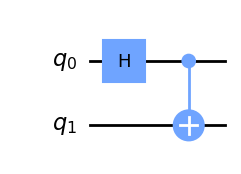

In [19]:
# Also it is possible to retrieve the circuit that has been run for specific job
first_job = jobs[1]
first_job_qasm = first_job.get_qasm() # Get OpenQASM string
first_job_circuit = first_job.get_circuit()
first_job_circuit.draw('mpl')

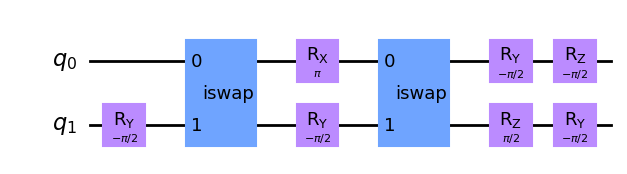

In [20]:
# Getting the transpiled circuit
# NOTICE: It can be possible that due tu bug in Qiskit's transpile function some circuits are wrongly converted to QASM string

first_job_transpiled_qasm = first_job.get_qasm(transpiled=True) # Get transpiled OpenQASM string
first_job_transpiled_circuit = first_job.get_circuit(transpiled=True)
first_job_transpiled_circuit.draw('mpl')

#### Query job by UUID

Jobs can be searched by their UUID using the `get_job()` method.

In [21]:
# Jobs can be queried by theirs UUID
job_uuid = first_job.job_id()
search_job = c12_simulator_backend.get_job(job_uuid)

print(f"Job id : {search_job.job_id()} {search_job.status()}")

Job id : 7b646f18-198d-40d7-a3f1-cb87cb6cc7a7 JobStatus.DONE


### Running multiple jobs at once

The `run()` method of the backend class can also accept the list of QuantumCircuit. This can be an essential feature as it allows a user to run multiple circuits simultaneously and get an array of job instances as a result.

In [22]:
# Array where the circuits will be stored
circuits_to_run = []

# Creating the circuits
circuit_1 = QuantumCircuit(2)
circuit_1.h(0)
circuit_1.cx(0, 1)

circuit_2 = QuantumCircuit(3)
circuit_2.h(0)
circuit_2.cx(0, 1)
circuit_2.x(2)
circuit_2.h(2)

circuits_to_run.append(circuit_1)
circuits_to_run.append(circuit_2)

# Running the jobs
c12_jobs = c12_simulator_backend.run(circuits_to_run)

# Printing the UUID of the jobs
for job in c12_jobs:
    print(f"Job id: {job.job_id()} - >  {job.status()}")

# Waiting for the results
for job in c12_jobs:
    result = job.result()
    print(result.get_statevector())

Job id: 87cf6476-5366-4b97-be21-b038525e1b56 - >  JobStatus.RUNNING
Job id: aa55dc98-b662-452c-b45b-15ff4145d066 - >  JobStatus.RUNNING
[0.49906378+1.35518698e-21j 0.00067965-2.03294274e-21j
 0.00106109+1.35518905e-21j 0.49919548-2.03294066e-21j]
[0.24953264+6.77595519e-22j 0.00033982-1.01647441e-21j
 0.00053055+6.77596554e-22j 0.24959849-1.01647337e-21j
 0.24953114+6.77591464e-22j 0.00033982-1.01646833e-21j
 0.00053055+6.77592499e-22j 0.24959699-1.01646729e-21j]
